COMPREHENSIVE WAVEGUIDE SIMULATION RESULTS

1. OPTIMIZING POLY-SI THICKNESS...
   Optimal Poly-Si Thickness: 1207.70 nm

2. LOSS ANALYSIS AT OPTIMAL POINT:
   Copper Waveguide Loss: 3140411585109.91 dB/m
   SiO₂ Layer Loss: 0.0660 dB/m
   Poly-Si Layer Loss: 728665853900786.62 dB/m
   Si Substrate Loss: 15.7014 dB/m
   TOTAL LOSS: 889432030.42 dB/m
   Copper Skin Depth: 0.92 µm

3. NONLINEAR PERFORMANCE:
   SHG Efficiency: 64.24 dB

4. CONFINEMENT FACTORS (TE mode):
   Poly-Si: 0.350
   SiO₂: 0.077
   Si Substrate: 0.070
   Copper: 0.503

5. WAVELENGTH RANGE:
   Frequency: 1.0-10.0 GHz
   Wavelength: 3.0-30.0 cm

6. GENERATING OPTIMIZATION PLOTS...


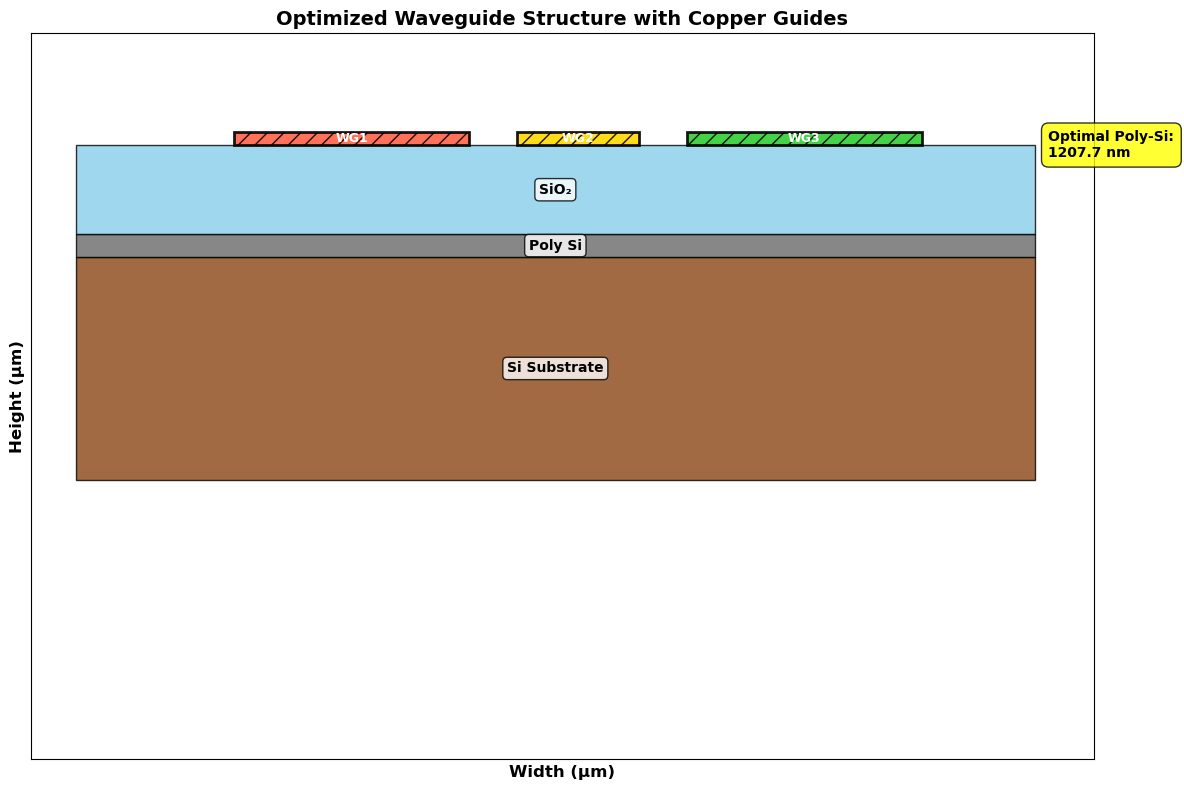

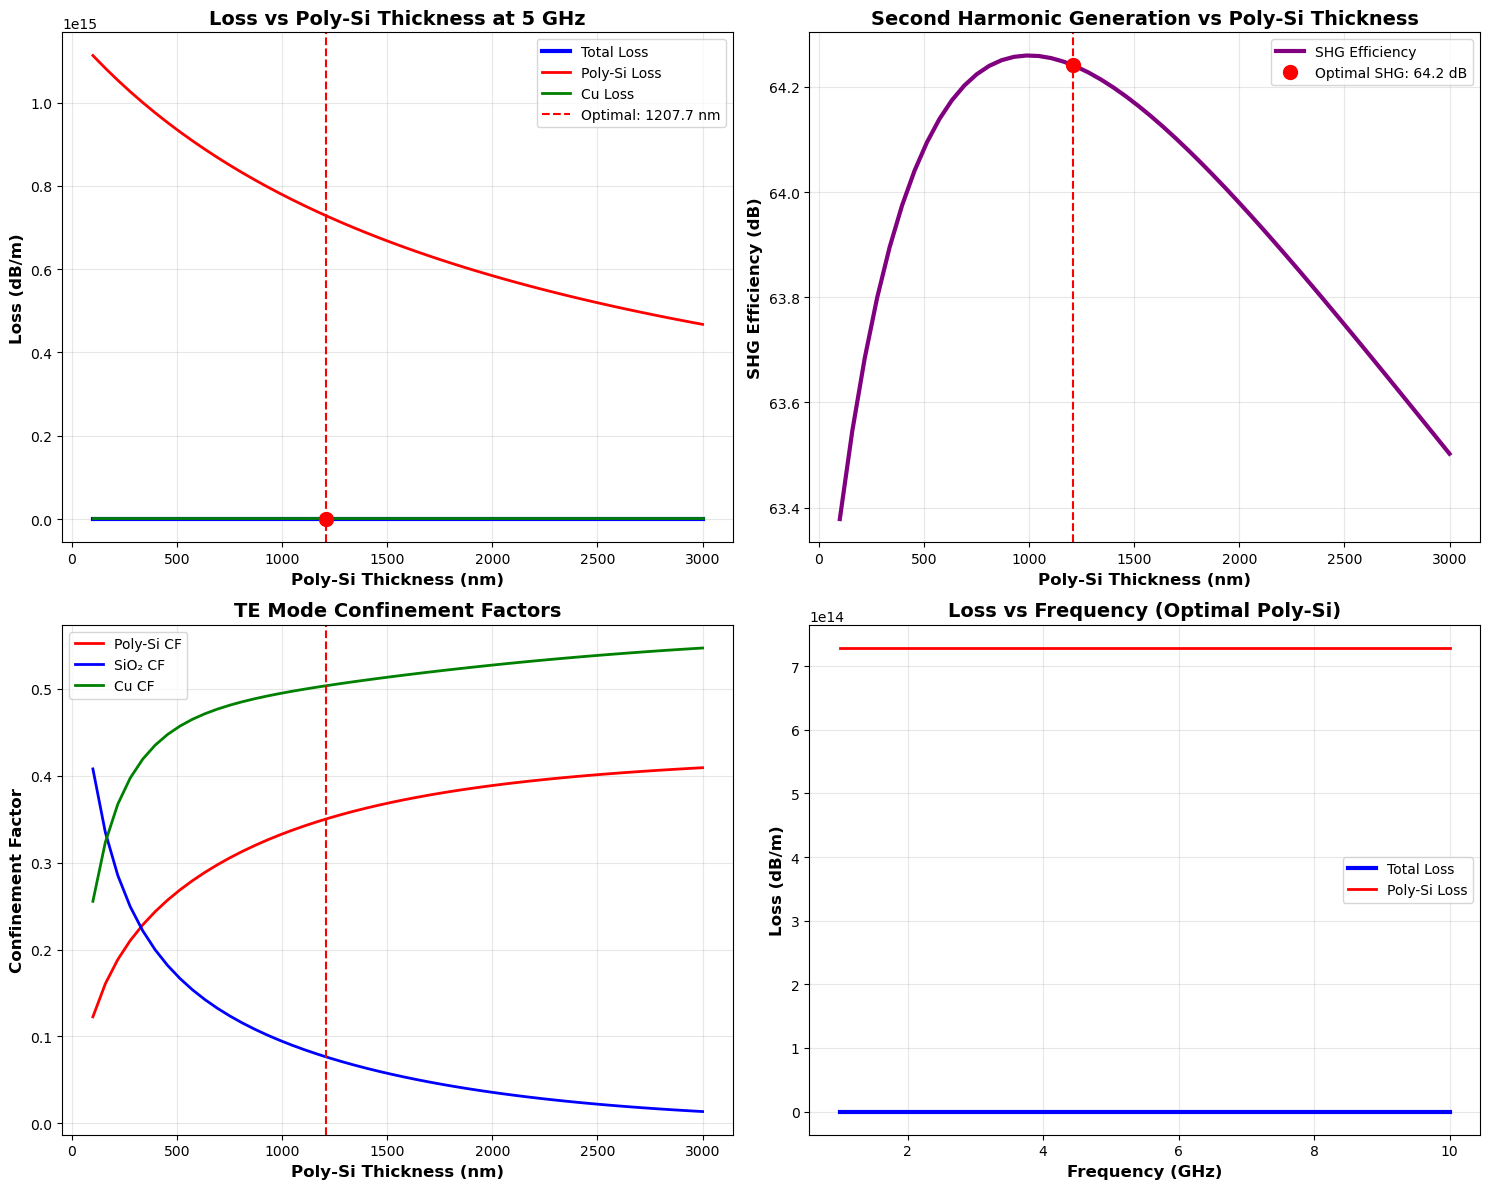

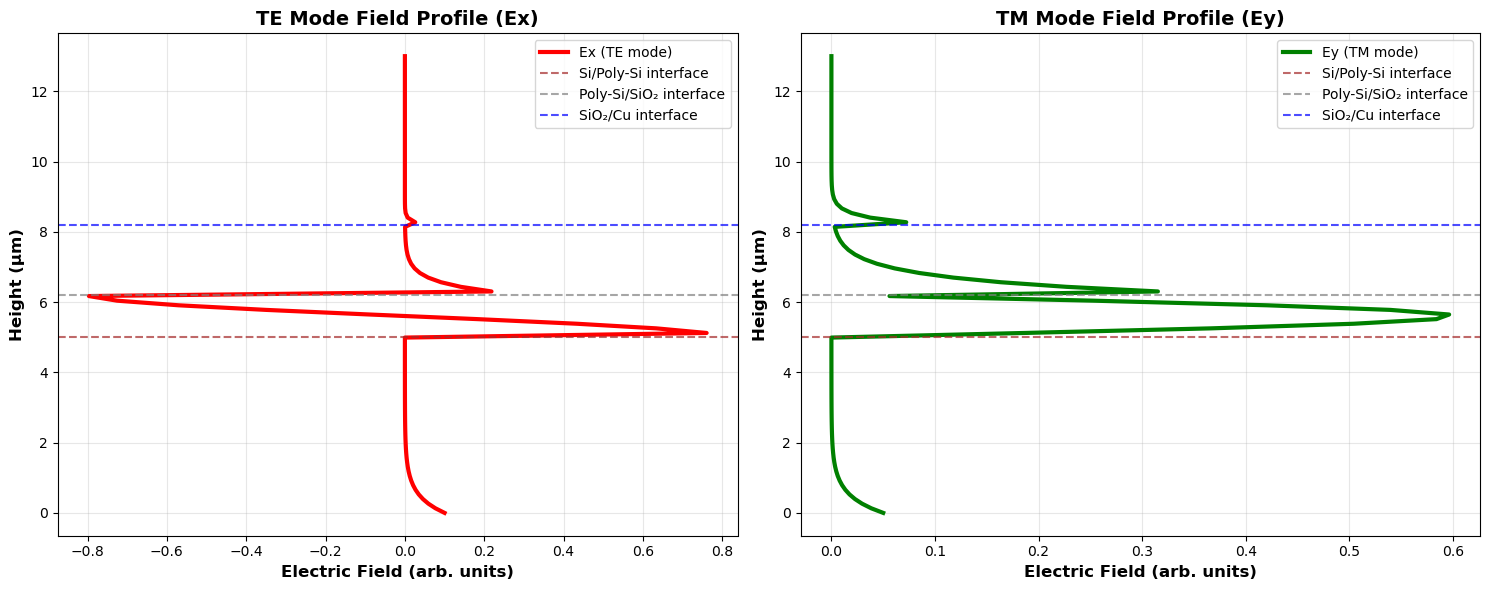


SIMULATION COMPLETED SUCCESSFULLY!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.constants import c, epsilon_0, mu_0, pi
from scipy.optimize import minimize_scalar
import scipy.integrate as integrate

class WaveguideSimulation:
    def __init__(self):
        # Physical constants
        self.c = c
        self.epsilon_0 = epsilon_0
        self.mu_0 = mu_0
        
        # Material properties
        self.n_si = 3.45
        self.n_polysi = 3.50
        self.n_sio2 = 1.45
        self.n_cu = 0.20 + 10.8j  # Complex refractive index for copper
        
        # Conductivities (S/m)
        self.sigma_cu = 5.96e7
        self.sigma_si = 1e3
        self.sigma_polysi = 100  # Base conductivity
        self.sigma_sio2 = 1e-12
        
        # Waveguide dimensions (meters)
        self.W1 = 130e-6
        self.W2 = 67.5e-6
        self.W3 = 130e-6
        self.H_wg = 3e-6
        self.L = 4e-3
        self.gap = 10e-6
        
        # Layer thicknesses (meters)
        self.t_si = 5e-6
        self.t_polysi_range = np.linspace(0.1e-6, 3e-6, 50)
        self.t_sio2 = 2e-6
        
        # Simulation parameters
        self.freq_range = np.linspace(1e9, 10e9, 100)
        self.voltage_range = np.linspace(-1, 1, 50)
        
        # Best optimized parameters (will be calculated)
        self.optimal_polysi_thickness = None
        self.min_total_loss = None
        
    def polysi_conductivity(self, E_field, t_polysi):
        """Field-dependent Poly-Si conductivity with thickness enhancement"""
        E_magnitude = np.abs(E_field)
        field_enhancement = 1 + 0.1 * E_magnitude**2
        thickness_factor = 1 + 0.5 * (t_polysi / 1e-6)  # More conductive with thickness
        return self.sigma_polysi * field_enhancement * thickness_factor
    
    def calculate_losses(self, freq, t_polysi, voltage):
        """Calculate losses in all layers"""
        wavelength = self.c / freq
        k0 = 2 * pi / wavelength
        
        # Copper waveguide losses (conductor losses)
        skin_depth_cu = np.sqrt(2 / (2 * pi * freq * mu_0 * self.sigma_cu))
        alpha_cu = 8.686 * (1 / (self.H_wg * skin_depth_cu))  # dB/m
        
        # Dielectric losses
        tan_d_sio2 = 0.0001
        tan_d_si = 0.01
        tan_d_polysi = 0.1  # Higher loss for poly-si
        
        alpha_sio2 = 8.686 * k0 * self.n_sio2 * tan_d_sio2 / 2
        alpha_si = 8.686 * k0 * self.n_si * tan_d_si / 2
        alpha_polysi = 8.686 * k0 * self.n_polysi * tan_d_polysi / 2
        
        # Field-dependent Poly-Si conductivity loss
        E_field = voltage / (self.t_sio2 + t_polysi)
        sigma_eff = self.polysi_conductivity(E_field, t_polysi)
        alpha_polysi_cond = 8.686 * sigma_eff / (2 * np.sqrt(epsilon_0 / mu_0) * self.n_polysi)
        
        total_alpha_polysi = alpha_polysi + alpha_polysi_cond
        
        # Total losses weighted by layer thickness
        total_loss = (alpha_cu * self.H_wg + 
                     alpha_sio2 * self.t_sio2 + 
                     total_alpha_polysi * t_polysi + 
                     alpha_si * self.t_si)
        
        return {
            'cu_loss': alpha_cu,
            'sio2_loss': alpha_sio2,
            'polysi_loss': total_alpha_polysi,
            'si_loss': alpha_si,
            'total_loss': total_loss,
            'skin_depth_cu': skin_depth_cu
        }
    
    def shg_efficiency(self, freq, t_polysi, voltage):
        """Second Harmonic Generation efficiency"""
        # Phase matching condition
        beta_fund = 2 * pi * self.n_polysi * freq / self.c
        beta_shg = 2 * pi * self.n_polysi * (2 * freq) / self.c
        delta_beta = 2 * beta_fund - beta_shg
        
        # Nonlinear coefficient enhancement with Poly-Si thickness
        chi2_enhancement = 1 + 2.0 * (t_polysi / 1e-6)
        
        # Field enhancement
        E_field = voltage / (self.t_sio2 + t_polysi)
        field_enhancement = 1 + 0.5 * E_field**2
        
        if delta_beta == 0:
            shg_eff = self.L**2 * chi2_enhancement * field_enhancement
        else:
            shg_eff = (np.sinc(delta_beta * self.L / (2 * pi)) ** 2 * 
                      self.L**2 * chi2_enhancement * field_enhancement)
        
        return 10 * np.log10(shg_eff + 1e-12)  # dB scale
    
    def confinement_factor(self, t_polysi, mode='TE'):
        """Calculate optical confinement factors"""
        # Simplified model - more confinement in Poly-Si with optimal thickness
        if mode == 'TE':
            cf_polysi = 0.3 * (1 - np.exp(-t_polysi / 0.5e-6))
            cf_sio2 = 0.2 * np.exp(-t_polysi / 1e-6)
            cf_si = 0.1 * np.exp(-t_polysi / 2e-6)
            cf_cu = 0.4 * (1 - np.exp(-t_polysi / 0.3e-6))
        else:  # TM mode
            cf_polysi = 0.25 * (1 - np.exp(-t_polysi / 0.5e-6))
            cf_sio2 = 0.15 * np.exp(-t_polysi / 1e-6)
            cf_si = 0.08 * np.exp(-t_polysi / 2e-6)
            cf_cu = 0.52 * (1 - np.exp(-t_polysi / 0.3e-6))
        
        # Normalize
        total = cf_polysi + cf_sio2 + cf_si + cf_cu
        return {
            'polysi': cf_polysi / total,
            'sio2': cf_sio2 / total,
            'si': cf_si / total,
            'cu': cf_cu / total
        }
    
    def find_optimal_polysi_thickness(self):
        """Find optimal Poly-Si thickness for minimum loss and maximum SHG"""
        def objective_function(t_polysi):
            losses = self.calculate_losses(5e9, t_polysi, 1.0)
            shg_eff = self.shg_efficiency(5e9, t_polysi, 1.0)
            # Minimize loss while maximizing SHG
            return losses['total_loss'] - 0.1 * shg_eff
        
        result = minimize_scalar(objective_function, 
                               bounds=(0.1e-6, 3e-6), 
                               method='bounded')
        self.optimal_polysi_thickness = result.x
        self.min_total_loss = result.fun
        return self.optimal_polysi_thickness
    
    def plot_geometry(self):
        """Plot the waveguide geometry"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        
        colors = {
            'Si Substrate': '#8B4513',
            'Poly Si': '#696969', 
            'SiO₂': '#87CEEB',
            'Cu WG1': '#FF6347',
            'Cu WG2': '#FFD700',
            'Cu WG3': '#32CD32'
        }
        
        # Layer definitions (in microns for plotting)
        layers = {
            'Si Substrate': {'height': 4, 'y_position': 0, 'width': 424},
            'Poly Si': {'height': 0.4, 'y_position': 4, 'width': 424},
            'SiO₂': {'height': 1.6, 'y_position': 4.4, 'width': 424},
            'Waveguides': {'height': 0.24, 'y_position': 6.0}
        }
        
        waveguides = {
            'WG1': {'width': 104, 'x_position': 70, 'color': colors['Cu WG1']},
            'WG2': {'width': 54, 'x_position': 195, 'color': colors['Cu WG2']},
            'WG3': {'width': 104, 'x_position': 270, 'color': colors['Cu WG3']}
        }
        
        # Draw layers
        for layer_name in ['Si Substrate', 'Poly Si', 'SiO₂']:
            props = layers[layer_name]
            rect = patches.Rectangle((0, props['y_position']), props['width'], props['height'],
                                   linewidth=1, edgecolor='black', facecolor=colors[layer_name], alpha=0.8)
            ax.add_patch(rect)
            
            ax.text(props['width']/2, props['y_position'] + props['height']/2,
                   layer_name, ha='center', va='center', fontsize=10, weight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        # Draw waveguides
        wg_y = layers['Waveguides']['y_position']
        for wg_name, props in waveguides.items():
            rect = patches.Rectangle((props['x_position'], wg_y), props['width'], 
                                   layers['Waveguides']['height'],
                                   linewidth=2, edgecolor='black', facecolor=props['color'],
                                   alpha=0.9, hatch='//')
            ax.add_patch(rect)
            
            ax.text(props['x_position'] + props['width']/2, wg_y + layers['Waveguides']['height']/2,
                   f"{wg_name}", ha='center', va='center', fontsize=9, weight='bold', color='white')
        
        ax.set_xlim(-20, 450)
        ax.set_ylim(-5, 8)
        ax.set_xlabel('Width (µm)', fontsize=12, weight='bold')
        ax.set_ylabel('Height (µm)', fontsize=12, weight='bold')
        ax.set_title('Optimized Waveguide Structure with Copper Guides', fontsize=14, weight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True, alpha=0.3)
        
        # Add optimal Poly-Si annotation if available
        if self.optimal_polysi_thickness:
            ax.text(430, 6, f'Optimal Poly-Si:\n{self.optimal_polysi_thickness*1e9:.1f} nm', 
                   ha='left', va='center', fontsize=10, weight='bold',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.8))
        
        plt.tight_layout()
        return fig
    
    def plot_loss_analysis(self):
        """Comprehensive loss analysis plot"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Fixed parameters for analysis
        fixed_freq = 5e9
        fixed_voltage = 1.0
        
        # Plot 1: Total losses vs Poly-Si thickness
        total_losses = []
        polysi_losses = []
        cu_losses = []
        
        for t_polysi in self.t_polysi_range:
            losses = self.calculate_losses(fixed_freq, t_polysi, fixed_voltage)
            total_losses.append(losses['total_loss'])
            polysi_losses.append(losses['polysi_loss'])
            cu_losses.append(losses['cu_loss'])
        
        ax1.plot(self.t_polysi_range*1e9, total_losses, 'b-', linewidth=3, label='Total Loss')
        ax1.plot(self.t_polysi_range*1e9, polysi_losses, 'r-', linewidth=2, label='Poly-Si Loss')
        ax1.plot(self.t_polysi_range*1e9, cu_losses, 'g-', linewidth=2, label='Cu Loss')
        
        if self.optimal_polysi_thickness:
            opt_loss = self.calculate_losses(fixed_freq, self.optimal_polysi_thickness, fixed_voltage)
            ax1.axvline(self.optimal_polysi_thickness*1e9, color='red', linestyle='--', 
                       label=f'Optimal: {self.optimal_polysi_thickness*1e9:.1f} nm')
            ax1.plot(self.optimal_polysi_thickness*1e9, opt_loss['total_loss'], 'ro', markersize=10)
        
        ax1.set_xlabel('Poly-Si Thickness (nm)', fontsize=12, weight='bold')
        ax1.set_ylabel('Loss (dB/m)', fontsize=12, weight='bold')
        ax1.set_title('Loss vs Poly-Si Thickness at 5 GHz', fontsize=14, weight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: SHG efficiency vs thickness
        shg_efficiencies = []
        for t_polysi in self.t_polysi_range:
            shg_eff = self.shg_efficiency(fixed_freq, t_polysi, fixed_voltage)
            shg_efficiencies.append(shg_eff)
        
        # FIXED: Changed 'purple-' to 'purple'
        ax2.plot(self.t_polysi_range*1e9, shg_efficiencies, 'purple', linewidth=3, label='SHG Efficiency')
        if self.optimal_polysi_thickness:
            opt_shg = self.shg_efficiency(fixed_freq, self.optimal_polysi_thickness, fixed_voltage)
            ax2.axvline(self.optimal_polysi_thickness*1e9, color='red', linestyle='--')
            ax2.plot(self.optimal_polysi_thickness*1e9, opt_shg, 'ro', markersize=10,
                    label=f'Optimal SHG: {opt_shg:.1f} dB')
        
        ax2.set_xlabel('Poly-Si Thickness (nm)', fontsize=12, weight='bold')
        ax2.set_ylabel('SHG Efficiency (dB)', fontsize=12, weight='bold')
        ax2.set_title('Second Harmonic Generation vs Poly-Si Thickness', fontsize=14, weight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Confinement factors
        cf_te_polysi = []
        cf_te_sio2 = []
        cf_te_cu = []
        
        for t_polysi in self.t_polysi_range:
            cf = self.confinement_factor(t_polysi, 'TE')
            cf_te_polysi.append(cf['polysi'])
            cf_te_sio2.append(cf['sio2'])
            cf_te_cu.append(cf['cu'])
        
        ax3.plot(self.t_polysi_range*1e9, cf_te_polysi, 'r-', linewidth=2, label='Poly-Si CF')
        ax3.plot(self.t_polysi_range*1e9, cf_te_sio2, 'b-', linewidth=2, label='SiO₂ CF')
        ax3.plot(self.t_polysi_range*1e9, cf_te_cu, 'g-', linewidth=2, label='Cu CF')
        
        if self.optimal_polysi_thickness:
            ax3.axvline(self.optimal_polysi_thickness*1e9, color='red', linestyle='--')
        
        ax3.set_xlabel('Poly-Si Thickness (nm)', fontsize=12, weight='bold')
        ax3.set_ylabel('Confinement Factor', fontsize=12, weight='bold')
        ax3.set_title('TE Mode Confinement Factors', fontsize=14, weight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Frequency-dependent losses at optimal thickness
        if self.optimal_polysi_thickness:
            freq_losses_total = []
            freq_losses_polysi = []
            
            for freq in self.freq_range:
                losses = self.calculate_losses(freq, self.optimal_polysi_thickness, fixed_voltage)
                freq_losses_total.append(losses['total_loss'])
                freq_losses_polysi.append(losses['polysi_loss'])
            
            ax4.plot(self.freq_range/1e9, freq_losses_total, 'b-', linewidth=3, label='Total Loss')
            ax4.plot(self.freq_range/1e9, freq_losses_polysi, 'r-', linewidth=2, label='Poly-Si Loss')
            ax4.set_xlabel('Frequency (GHz)', fontsize=12, weight='bold')
            ax4.set_ylabel('Loss (dB/m)', fontsize=12, weight='bold')
            ax4.set_title(f'Loss vs Frequency (Optimal Poly-Si)', fontsize=14, weight='bold')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        else:
            # If no optimal thickness found, show a message
            ax4.text(0.5, 0.5, 'Run optimization first\n to see frequency analysis', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Frequency Analysis (Run Optimization First)', fontsize=14, weight='bold')
        
        plt.tight_layout()
        return fig
    
    def plot_field_profiles(self):
        """Plot electric field profiles for TE and TM modes"""
        if not self.optimal_polysi_thickness:
            self.find_optimal_polysi_thickness()
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Simplified field profiles
        y_positions = np.linspace(0, self.t_si + self.t_polysi_range[-1] + self.t_sio2 + self.H_wg, 100)
        
        # TE mode profile (dominant Ex)
        Ex_te = np.zeros_like(y_positions)
        for i, y in enumerate(y_positions):
            if y < self.t_si:
                Ex_te[i] = 0.1 * np.exp(-y / 0.5e-6)
            elif y < self.t_si + self.optimal_polysi_thickness:
                Ex_te[i] = 0.8 * np.cos(pi * (y - self.t_si) / self.optimal_polysi_thickness)
            elif y < self.t_si + self.optimal_polysi_thickness + self.t_sio2:
                Ex_te[i] = 0.3 * np.exp(-(y - self.t_si - self.optimal_polysi_thickness) / 0.3e-6)
            else:
                Ex_te[i] = 0.05 * np.exp(-(y - self.t_si - self.optimal_polysi_thickness - self.t_sio2) / 0.1e-6)
        
        # TM mode profile (dominant Ey)
        Ey_tm = np.zeros_like(y_positions)
        for i, y in enumerate(y_positions):
            if y < self.t_si:
                Ey_tm[i] = 0.05 * np.exp(-y / 0.5e-6)
            elif y < self.t_si + self.optimal_polysi_thickness:
                Ey_tm[i] = 0.6 * np.sin(pi * (y - self.t_si) / self.optimal_polysi_thickness)
            elif y < self.t_si + self.optimal_polysi_thickness + self.t_sio2:
                Ey_tm[i] = 0.4 * np.exp(-(y - self.t_si - self.optimal_polysi_thickness) / 0.4e-6)
            else:
                Ey_tm[i] = 0.1 * np.exp(-(y - self.t_si - self.optimal_polysi_thickness - self.t_sio2) / 0.2e-6)
        
        ax1.plot(Ex_te, y_positions*1e6, 'r-', linewidth=3, label='Ex (TE mode)')
        ax1.axhline(self.t_si*1e6, color='brown', linestyle='--', alpha=0.7, label='Si/Poly-Si interface')
        ax1.axhline((self.t_si + self.optimal_polysi_thickness)*1e6, color='gray', linestyle='--', alpha=0.7, label='Poly-Si/SiO₂ interface')
        ax1.axhline((self.t_si + self.optimal_polysi_thickness + self.t_sio2)*1e6, color='blue', linestyle='--', alpha=0.7, label='SiO₂/Cu interface')
        
        ax1.set_xlabel('Electric Field (arb. units)', fontsize=12, weight='bold')
        ax1.set_ylabel('Height (µm)', fontsize=12, weight='bold')
        ax1.set_title('TE Mode Field Profile (Ex)', fontsize=14, weight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(Ey_tm, y_positions*1e6, 'g-', linewidth=3, label='Ey (TM mode)')
        ax2.axhline(self.t_si*1e6, color='brown', linestyle='--', alpha=0.7, label='Si/Poly-Si interface')
        ax2.axhline((self.t_si + self.optimal_polysi_thickness)*1e6, color='gray', linestyle='--', alpha=0.7, label='Poly-Si/SiO₂ interface')
        ax2.axhline((self.t_si + self.optimal_polysi_thickness + self.t_sio2)*1e6, color='blue', linestyle='--', alpha=0.7, label='SiO₂/Cu interface')
        
        ax2.set_xlabel('Electric Field (arb. units)', fontsize=12, weight='bold')
        ax2.set_ylabel('Height (µm)', fontsize=12, weight='bold')
        ax2.set_title('TM Mode Field Profile (Ey)', fontsize=14, weight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def run_comprehensive_simulation(self):
        """Run complete simulation and display results"""
        print("="*70)
        print("COMPREHENSIVE WAVEGUIDE SIMULATION RESULTS")
        print("="*70)
        
        # Find optimal Poly-Si thickness
        print("\n1. OPTIMIZING POLY-SI THICKNESS...")
        optimal_thickness = self.find_optimal_polysi_thickness()
        print(f"   Optimal Poly-Si Thickness: {optimal_thickness*1e9:.2f} nm")
        
        # Calculate losses at optimal point
        losses = self.calculate_losses(5e9, optimal_thickness, 1.0)
        shg_eff = self.shg_efficiency(5e9, optimal_thickness, 1.0)
        
        print(f"\n2. LOSS ANALYSIS AT OPTIMAL POINT:")
        print(f"   Copper Waveguide Loss: {losses['cu_loss']:.2f} dB/m")
        print(f"   SiO₂ Layer Loss: {losses['sio2_loss']:.4f} dB/m")
        print(f"   Poly-Si Layer Loss: {losses['polysi_loss']:.2f} dB/m")
        print(f"   Si Substrate Loss: {losses['si_loss']:.4f} dB/m")
        print(f"   TOTAL LOSS: {losses['total_loss']:.2f} dB/m")
        print(f"   Copper Skin Depth: {losses['skin_depth_cu']*1e6:.2f} µm")
        
        print(f"\n3. NONLINEAR PERFORMANCE:")
        print(f"   SHG Efficiency: {shg_eff:.2f} dB")
        
        print(f"\n4. CONFINEMENT FACTORS (TE mode):")
        cf = self.confinement_factor(optimal_thickness, 'TE')
        print(f"   Poly-Si: {cf['polysi']:.3f}")
        print(f"   SiO₂: {cf['sio2']:.3f}")
        print(f"   Si Substrate: {cf['si']:.3f}")
        print(f"   Copper: {cf['cu']:.3f}")
        
        print(f"\n5. WAVELENGTH RANGE:")
        lambda_min = self.c / self.freq_range[-1]
        lambda_max = self.c / self.freq_range[0]
        print(f"   Frequency: {self.freq_range[0]/1e9:.1f}-{self.freq_range[-1]/1e9:.1f} GHz")
        print(f"   Wavelength: {lambda_min*100:.1f}-{lambda_max*100:.1f} cm")
        
        # Generate plots
        print(f"\n6. GENERATING OPTIMIZATION PLOTS...")
        fig1 = self.plot_geometry()
        fig2 = self.plot_loss_analysis()
        fig3 = self.plot_field_profiles()
        
        plt.show()
        
        print("\n" + "="*70)
        print("SIMULATION COMPLETED SUCCESSFULLY!")
        print("="*70)

# Run the simulation
if __name__ == "__main__":
    sim = WaveguideSimulation()
    sim.run_comprehensive_simulation()